<a href="https://colab.research.google.com/github/luandinhngo/Artificial-Intelligence/blob/main/Baseline_NLI_tf_1_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, pickle, re, keras, sklearn, string
np.random.seed(0)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [2]:
!nvidia-smi

Fri Oct 29 08:13:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers
from transformers import TFAutoModel,AutoTokenizer
import tensorflow as tf
!pip install sentencepiece
!pip install pyyaml h5py

     |████████████████████████████████| 3.1 MB 13.2 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 3.3 MB 59.2 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 13.0 MB/s 


#K-Fold


In [5]:
tokenizer=AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1024)
fold_no = 1
df = shuffle(train)
y = df['label']
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
train_df_list = []
val_df_list = []
fold_list = list(kf.split(df, y))
for i, fold in enumerate(fold_list):
  df_train = df[df.index.isin(fold[0])]
  df_val = df[df.index.isin(fold[1])]
  train_df_list.append(df_train)
  val_df_list.append(df_val)
  print(i)
  

0
1
2
3
4
5
6
7
8
9


In [ ]:
cd /content/drive/MyDrive/VLSP/weight_10_fold

/content/drive/MyDrive/VLSP/weight_10_fold


In [6]:
with strategy.scope():
    input_ids = tf.keras.Input(shape = (100,), dtype = tf.int32,name='input_word_ids') 
    input_mask=tf.keras.Input(shape=(100,),dtype=tf.int32,name='input_mask')    
    roberta = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    roberta = roberta([input_ids,input_mask])[0]
    output = tf.keras.layers.GlobalAveragePooling1D()(roberta)
    # output2 = tf.keras.layers.GlobalMaxPooling1D()(roberta)
    # output = tf.keras.layers.concatenate([output1,output2],axis=1)
    output = tf.keras.layers.Dense(3, activation = 'softmax')(output)
    model = tf.keras.Model(inputs = [input_ids,input_mask], outputs = output)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    model.summary()

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           tfxlm_roberta_model[0][0]    

In [7]:
data_train = pd.read_csv('/content/drive/MyDrive/VLSP/data_10_fold/train_df_fold_0.csv')
data_valid = pd.read_csv('/content/drive/MyDrive/VLSP/data_10_fold/val_df_fold_0.csv')

In [8]:
data_valid["label"].value_counts()

0    544
1    542
2    532
Name: label, dtype: int64

In [10]:
from sklearn.model_selection import KFold
import os
acc_per_fold = []
loss_per_fold = []
fold_no = 1

# for i in range(1): 
  # model = create_model()
  # data_train = train_df_list[1]
  # data_valid = val_df_list[1]
i=0
# checkpoint_path ="/content/drive/MyDrive/VLSP/weight_10_fold/flod"+str(i)+"-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path[i])

train_enc=tokenizer.batch_encode_plus(data_train[['sentence_1','sentence_2']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)
train_tf1=tf.convert_to_tensor(train_enc['input_ids'],dtype=tf.int32)
train_tf2=tf.convert_to_tensor(train_enc['attention_mask'],dtype=tf.int32)
train_input={'input_word_ids':train_tf1,'input_mask':train_tf2}
test_enc=tokenizer.batch_encode_plus(data_valid[['sentence_1','sentence_2']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)
test_tf1=tf.convert_to_tensor(test_enc['input_ids'],dtype=tf.int32)
test_tf2=tf.convert_to_tensor(test_enc['attention_mask'],dtype=tf.int32)
test_input={'input_word_ids':test_tf1,'input_mask':test_tf2}

#test
  # danhgia_enc=tokenizer.batch_encode_plus(test[['sentence_1','sentence_2']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)
  # danhgia_tf1=tf.convert_to_tensor(danhgia_enc['input_ids'],dtype=tf.int32)
  # danhgia_tf2=tf.convert_to_tensor(danhgia_enc['attention_mask'],dtype=tf.int32)
  # danhgia_input={'input_word_ids':danhgia_tf1,'input_mask':danhgia_tf2}

    
  # Generate a print
print(f'Training for fold {i} ...')
print('------------------------------------------------------------------------')
# early_stop = tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
              
history = model.fit(train_input,np.asarray(data_train.label).astype(np.int32),
                    epochs=3,
              validation_data=(test_input, np.asarray(data_valid.label).astype(np.int32)),
              batch_size=16*strategy.num_replicas_in_sync,
              # callbacks=[cp_callback,early_stop],
              verbose=1)

    # Generate generalization metrics
scores = model.evaluate(test_input,np.asarray(data_valid.label).astype(np.int32), verbose=1)
print(f'Score for fold {i}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])
data_train=[]
data_valid=[]
# i+=1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Training for fold 0 ...
------------------------------------------------------------------------
Epoch 1/3
910/910 [==============================] - 662s 698ms/step - loss: 0.2921 - accuracy: 0.9012 - val_loss: 0.1793 - val_accuracy: 0.9376
Epoch 2/3
910/910 [==============================] - 630s 692ms/step - loss: 0.1456 - accuracy: 0.9529 - val_loss: 0.1494 - val_accuracy: 0.9493
Epoch 3/3
51/51 [==============================] - 20s 392ms/step - loss: 0.1513 - accuracy: 0.9561
Score for fold 0: loss of 0.15130159258842468; accuracy of 95.6118643283844%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.15130159258842468 - Accuracy: 95.6118643283844%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 95.6118643283844 (+- 0.0)
> Loss: 0.15130159258842468
---------------------------------------

#predict_1_fold


In [ ]:
y=model.predict(test_input)

In [ ]:
l = [np.argmax(y[i]) for i in range(len(y))]

In [ ]:
val["gold_label"]=l

In [ ]:
val

,Unnamed: 0,Unnamed: 0.1,id,lang_1,lang_2,sentence_1,sentence_2,label,gold_label
0,12452,12467,train_12467,en,vi,As coronavirus cases continue to fluctuate in ...,Nhiều nước trên thế giới đã bắt đầu nghiên cứu...,1,1
1,11811,11826,train_11826,vi,vi,"Vào thứ Tư vừa qua, các nhà lập pháp của bang ...",Các nhà lập pháp ở Nam Carolina đã yêu cầu côn...,1,1
2,11227,11242,train_11242,en,vi,There is growing concern across Arizona as inf...,Nhiều người tại Arizona đã phải nhập viện do v...,1,1
3,3197,3201,train_3201,vi,vi,Việt Nam cho biết chủng coronavirus mới là ngu...,"Việt Nam cho rằng, chủng coronavirus mới với k...",0,0
4,12427,12442,train_12442,en,vi,A new study from South Korea has found that pe...,Một báo cáo mới của Reuters cho thấy một nghiê...,0,0
...,...,...,...,...,...,...,...,...,...
1613,7877,7887,train_7887,vi,vi,David Israel được chẩn đoán mắc bệnh ung thư h...,Năm 2015 David Israel nhận kết quả xét nghiệm ...,0,0
1614,15846,15870,train_15870,en,vi,The toxin believed to have poisoned Russian op...,Alexei Navalny từng là thành viên Hội đồng điề...,1,1
1615,705,706,train_706,en,vi,Though a University of Virginia model now proj...,Khi Đại học Virginia có thể đoán trước được ca...,2,2
1616,5874,5881,train_5881,vi,vi,Khi nhà đồng hồ học người Pháp Abraham-Louis B...,Nhà đồng hồ học người Pháp Abraham-Louis Bregu...,0,0


In [ ]:
val["label"].value_counts()

1    560
2    534
0    524
Name: label, dtype: int64

In [ ]:
df=val

In [ ]:
df =df.reset_index(drop=True)

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,id,lang_1,lang_2,sentence_1,sentence_2,label,gold_label
0,11235,11250,train_11250,vi,vi,Thống đốc bang Arizona Doug Ducey có thể giảm ...,Bệnh viện đang nỗ lực để thực hiện ca phẫu thu...,1,1
1,12501,12516,train_12516,en,vi,South Dakota is set to become the first state ...,Tính hiệu quả của hydroxychloroquine trong điề...,0,0
2,13911,13930,train_13930,vi,vi,Viêm gan B mãn tính cho tới nay vẫn chưa có ph...,Phương pháp điều trị chủ yếu cho bệnh viêm gan...,1,1
3,14134,14155,train_14155,vi,vi,"Tiến sĩ Ashish Jha, Giám đốc Viện Y tế Toàn cầ...","Tiến sĩ Ashish Jha, Giám đốc Viện Y tế Toàn cầ...",1,1
4,5530,5537,train_5537,vi,vi,"Dù phết lên bánh mì nướng, thêm vào cháo hay c...",Đa số mọi người đều sử dụng đường khi ăn bánh ...,2,2
...,...,...,...,...,...,...,...,...,...
1613,10148,10159,train_10159,en,vi,Gov. Mike Dunleavy held a press conference on ...,Một cuộc họp báo kêu gọi người dân duy trì việ...,0,0
1614,2046,2049,train_2049,en,vi,An election night that ended with no clear win...,Sự thật là các cử tri Mỹ đã mong muốn nới lỏng...,0,0
1615,2897,2901,train_2901,vi,vi,17 thượng nghị sĩ đảng Dân chủ đã gửi một lá t...,17 thành viên Thượng viện của đảng Dân chủ đã ...,2,2
1616,6744,6752,train_6752,en,vi,"For the third day in a row, Illinois is report...",Bang Illinois phải tuyên bố tình trạng khẩn cấ...,1,1


In [ ]:
df["gold_label"]=df["gold_label"].map({0: 'agree', 1: 'neutral', 2:'disagree' })

In [ ]:
df["label"]=df["label"].map({0: 'agree', 1: 'neutral', 2:'disagree' })

In [ ]:
data=[]
for i in range(len(df)):
  data.append({
      "id":df["id"][i],"gold_label":df["gold_label"][i]
  })

In [ ]:
data1=[]
for i in range(len(df)):
  data1.append({
      "id":df["id"][i],"label":df["label"][i]
  })

In [ ]:
import json
with open ('gold_lbale_kflod2_3epoch.json', 'w') as outfile:
	json.dump(data, outfile, indent=2)
	print("File Dumped as testout.json")

File Dumped as testout.json


In [ ]:
with open ('pedict_lbale_kflod2_3epoch.json', 'w') as outfile:
	json.dump(data1, outfile, indent=2)
	print("File Dumped as testout.json")

File Dumped as testout.json


In [ ]:
cd /content/drive/MyDrive/tinyeudau

/content/drive/MyDrive/tinyeudau


In [ ]:
!cp pedict_lbale_kflod0.json /content

In [ ]:
cd /content

/content


fold1: 
Label map: {'agree': 0, 'neutral': 1, 'disagree': 2}
Check data format:  /content/drive/MyDrive/tinyeudau/pedict_lbale_kflod2_3epoch.json
OK.
Check data format:  /content/drive/MyDrive/tinyeudau/gold_lbale_kflod2_3epoch.json
OK.
Check data consistency: 
OK.
Evaluation result:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       516
           1       0.99      0.91      0.95       605
           2       0.90      0.96      0.93       497

    accuracy                           0.94      1618
   macro avg       0.94      0.95      0.94      1618
weighted avg       0.95      0.94      0.94      1618



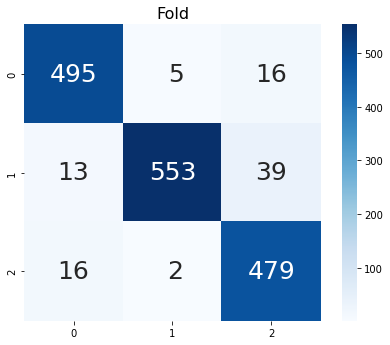

In [ ]:
import json
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def vlsp_nli_eval(gold_json_file, prediction_json_file):

    gold_json = json.load(open(gold_json_file, 'rt', encoding='utf-8'))
    prediction_json = json.load(
        open(prediction_json_file, 'rt', encoding='utf-8'))

    label_map = {'agree': 0, 'neutral': 1, 'disagree': 2}
    print('Label map:', label_map)

    print('Check data format: ', prediction_json_file)

    check_format = True
    for p in prediction_json:
        if 'label' not in p or 'id' not in p or p['label'] not in label_map:
            check_format = False
            print('Invalid label (format) in entry:', p)
            break

    if not check_format:
        print('Please correct the data format and try again')
        return
    else:
        print('OK.')

    print('Check data format: ', gold_json_file)
    check_format = True
    for p in gold_json:
        if 'gold_label' not in p or 'id' not in p or p['gold_label'] not in label_map:
            check_format = False
            print('Invalid label (format) in entry:', p)
            break

    if not check_format:
        print('Please correct the data format and try again')
        return
    else:
        print('OK.')

    print('Check data consistency: ')

    gold_dict = {p['id']: p['gold_label'] for p in gold_json}
    prediction_dict = {p['id']: p['label'] for p in prediction_json}

    consistency_check = True

    for key in gold_dict:
        if key not in prediction_dict:
            consistency_check = False
            print('Id', key, 'is not in the prediction data')
            break

    for key in prediction_dict:
        if key not in gold_dict:
            consistency_check = False
            print('Gold data does not contain id', key)
            break

    if not consistency_check:
        print('Please correct the data and try again')
        return
    else:
        print('OK.')

    id_list = list(gold_dict.keys())

    gold_labels = [label_map[gold_dict[idx]] for idx in id_list]

    prediction_labels = [label_map[prediction_dict[idx]] for idx in id_list]
    cm_cst_nb = confusion_matrix(gold_labels, prediction_labels)
# cm_txc_nb

    plt.figure(figsize=(17,12))
# plt.suptitle('Confusion Matrix: XLM-R ', fontsize=20)

    plt.subplot(2,2,1)
    plt.title('Fold', fontsize=16)
    df_cm_cst_nb = pd.DataFrame(cm_cst_nb)#, index=np.unique(cst_train), columns=np.unique(cst_test))
    sns.heatmap(df_cm_cst_nb, annot=True, square=True, annot_kws={"size": 25}, fmt='2g', cmap='Blues')
    # print(classification_report(y_label, pred, digits = 4))
    
    print('Evaluation result:\n')
    print(classification_report(gold_labels, prediction_labels))



if __name__ == '__main__':
    import sys

    # print(sys.argv)

    # if len(sys.argv) != 3:

    #     print('--- The command to run the evaluation script ---')
    #     print('   python vlsp_nli_eval.py [path_to_gold_file] [path_to_prediction_file]')
    #     print('Example: \n    python vlsp_nli_eval.py nli_gold.json nli_prediction.json')
    
    # else:
    #     gold_file = sys.argv[1]
    #     prediction_file = sys.argv[2]
    # for j in range(10):
    j=1
    print(f'fold{str(j)}: ')
    gold_file = f'/content/drive/MyDrive/tinyeudau/gold_lbale_kflod2_3epoch.json'
    prediction_file = f'/content/drive/MyDrive/tinyeudau/pedict_lbale_kflod2_3epoch.json'
    vlsp_nli_eval(gold_file,prediction_file)
    # gold_file = '/content/gold_json_file.json'
    # prediction_file = '/content/prediction_json_file.json'
    # vlsp_nli_eval(gold_file, prediction_file)
    


In [ ]:
df

,Unnamed: 0,id,lang_1,lang_2,sentence_1,sentence_2,label,gold_label,gold_lable
0,14912,train_14912,en,vi,Dejay Cartwright had visited more than 400 lig...,Dejay Cartwright chuẩn bị ghé thăm một ngọn hả...,0,agree,0
1,11896,train_11896,vi,vi,Một khách du lịch người Anh đang chiến đấu để ...,"Một viên khách người Anh, sau khi đặt chân đến...",0,agree,0
2,13502,train_13502,en,vi,Gilead Sciences Inc. shares were whipsawed for...,Việc thất bại trong lần thử nghiệm điều chế th...,0,agree,0
3,8751,train_8751,en,vi,A young child died Wednesday from COVID-19 and...,Một đứa trẻ nhiễm COVID-19 kèm theo các hội ch...,2,disagree,2
4,6426,train_6426,en,vi,Scientists in Thailand reported what they say ...,Mức độ hiệu quả của vắc xin Sinovac trở thành ...,1,neutral,1
...,...,...,...,...,...,...,...,...,...
1613,8354,train_8354,en,vi,Sunday marked the beginning of a breakthrough ...,Chủ nhật đã đánh dấu một mốc sự kiện quan trọn...,0,agree,0
1614,798,train_798,vi,vi,Trong bối cảnh căng thẳng ngày càng gia tăng g...,Đã xảy ra cãi vã giữa người đứng đầu Nhà Trắng...,1,neutral,1
1615,9904,train_9904,en,vi,The Maine Center for Disease Control and Preve...,Chưa có thêm trường hợp nhiễm virus corona nào...,2,disagree,2
1616,14040,train_14040,en,vi,"For weeks, frontline nurse Sette Buenaventura ...",Trong tình cảnh virus corona đang lây lan mạnh...,2,disagree,2


In [ ]:
l.shape

(334,)

In [ ]:
for i in range(len(train)):
  if train["label"][i]=="neutral":
     train["label"][i]=1
  if train["label"][i]=="agree":
     train["label"][i]=0
  if train["label"][i]=="disagree":
     train["label"][i]=2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train

,Unnamed: 0,id,lang_1,lang_2,sentence_1,sentence_2,label
0,0,train_0,en,vi,Some Maine congressional leaders are pushing t...,Một số lãnh đạo quốc hội Maine đang tiến hành ...,1
1,1,train_1,vi,vi,Tờ báo Dispatch đã bày tỏ sự ủng hộ mạnh mẽ đố...,Thống đốc thứ 70 của bang Ohio - Mike DeWine l...,1
2,2,train_2,en,vi,"Dr. Roberto Colon, the associate chief medical...",Sau khi ghi nhận ca tử vong do virus corona đầ...,1
3,3,train_3,en,vi,Austin Regional Clinic is looking for 250 volu...,Các cuộc thử nghiệm vắc-xin ngừa virus corona ...,0
4,4,train_4,vi,vi,Khi số ca nhiễm virus corona mới tăng trên khắ...,Indiana hiện đang rất nỗ lực để chiến đấu với ...,1
...,...,...,...,...,...,...,...
995,997,train_997,en,vi,Idaho will not receive as many doses of the Pf...,Một số nhân viên Sở Y tế Idaho sẽ được tiêm vắ...,1
996,998,train_998,en,vi,"With a record 10,002 coronavirus patients in T...",Thống đốc bang Texas (Mỹ) Greg Abbott gọi cuộc...,1
997,999,train_999,en,vi,"The Florida Department of Health reported 1,41...",Tình hình dịch bệnh tại Mỹ đang chuyển biến xấ...,1
998,1000,train_1000,vi,vi,Một nhân viên quản lý chuyên ngành trước của O...,"Sau một thời gian chiến đấu với COVID-19, một ...",0


In [ ]:
 data_valid.label

891       agree
192       agree
957    disagree
988     neutral
7         agree
         ...   
254       agree
538     neutral
886       agree
274       agree
822    disagree
Name: label, Length: 334, dtype: object

In [ ]:
model.evaluate(danhgia_input, test.label, verbose=1)


29/29 [==============================] - 22s 390ms/step - loss: 2.4789 - accuracy: 0.0978


[2.478933572769165, 0.09777777642011642]

In [ ]:
y[1]

array([0.01550913, 0.97897995, 0.00551097], dtype=float32)

In [ ]:
np.argmax(y[1])

1

In [ ]:
test

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,id,lang_1,lang_2,sentence_1,sentence_2,label,s1_en,s2_en
0,0,0,0,0,train_0,en,vi,Some Maine congressional leaders are pushing t...,Một số lãnh đạo quốc hội Maine đang tiến hành ...,1,Some Maine congressional leaders are pushing t...,Some leaders of Maine Parliament are conductin...
1,1,1,1,1,train_1,vi,vi,Tờ báo Dispatch đã bày tỏ sự ủng hộ mạnh mẽ đố...,Thống đốc thứ 70 của bang Ohio - Mike DeWine l...,1,The Dispatch newspaper expressed its strong su...,Ohio's 70th governor - Mike Dewine is a talent...
2,2,2,2,2,train_2,en,vi,"Dr. Roberto Colon, the associate chief medical...",Sau khi ghi nhận ca tử vong do virus corona đầ...,1,"Dr. Roberto Colon, the associate chief medical...",After recording the first Corona virus in the ...
3,3,3,3,3,train_3,en,vi,Austin Regional Clinic is looking for 250 volu...,Các cuộc thử nghiệm vắc-xin ngừa virus corona ...,0,Austin Regional Clinic is looking for 250 volu...,Pfizer Inc's new Corona virus vaccine tests on...
4,4,4,4,4,train_4,vi,vi,Khi số ca nhiễm virus corona mới tăng trên khắ...,Indiana hiện đang rất nỗ lực để chiến đấu với ...,1,When the number of Corona virus infections inc...,Indiana is currently working hard to fight Cov...
...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,895,932,932,train_932,en,vi,"Ebonie Guyton, a public health practitioner in...","Một bác sĩ y tế ở Detroit, Ebonie Guyton, đã n...",2,"Ebonie Guyton, a public health practitioner in...","A medical doctor in Detroit, Ebonie Guyton, sa..."
896,896,896,934,934,train_934,vi,vi,Các nhà nghiên cứu tại Đại học Toronto cảnh bá...,"Đồ nướng, bánh kẹo hoặc các loại thức ăn tẩm c...",2,Researchers at the University of Toronto warne...,"Barbecue, confectionery or other cannabis impr..."
897,897,897,943,943,train_943,en,vi,The South Dakota Department of Health reported...,Sở Y tế Nam Dakota không ghi nhận ca nhiễm COV...,2,The South Dakota Department of Health reported...,South Dakota Department of Health does not rec...
898,898,898,944,944,train_944,en,vi,"During Tuesday night’s presidential debate, Pr...",Tổng thống Trump không quan tâm tới các vấn đề...,2,"During Tuesday night’s presidential debate, Pr...",Trump President did not care about the issues ...


In [ ]:
!ls {checkpoint_dir}

checkpoint			     flod4-0002.ckpt.index
flod0-0001.ckpt.data-00000-of-00001  flod4-0003.ckpt.data-00000-of-00001
flod0-0001.ckpt.index		     flod4-0003.ckpt.index
flod0-0002.ckpt.data-00000-of-00001  flod5-0001.ckpt.data-00000-of-00001
flod0-0002.ckpt.index		     flod5-0001.ckpt.index
flod0-0003.ckpt.data-00000-of-00001  flod5-0002.ckpt.data-00000-of-00001
flod0-0003.ckpt.index		     flod5-0002.ckpt.index
flod0-0004.ckpt.data-00000-of-00001  flod5-0003.ckpt.data-00000-of-00001
flod0-0004.ckpt.index		     flod5-0003.ckpt.index
flod0-0005.ckpt.data-00000-of-00001  flod6-0001.ckpt.data-00000-of-00001
flod0-0005.ckpt.index		     flod6-0001.ckpt.index
flod1-0001.ckpt.data-00000-of-00001  flod6-0002.ckpt.data-00000-of-00001
flod1-0001.ckpt.index		     flod6-0002.ckpt.index
flod1-0002.ckpt.data-00000-of-00001  flod6-0003.ckpt.data-00000-of-00001
flod1-0002.ckpt.index		     flod6-0003.ckpt.index
flod1-0003.ckpt.data-00000-of-00001  flod7-0001.ckpt.data-00000-of-00001
flod1-0003.ckpt.index		   

In [ ]:
checkpoint_path ="flod"+str(1)+"-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname("/content/drive/MyDrive/VLSP/save/weight_en/checkpoint")

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/drive/MyDrive/VLSP/save/weight_en/flod9-0003.ckpt'

In [ ]:
checkpoint_path.format(epoch=00000)

'flod1-0000.ckpt'

In [ ]:
model.load_weights(latest)

In [ ]:
pred=[np.argmax(i) for i in model.predict(danhgia_input)]
pd.DataFrame(pred).value_counts()

2    304
0    304
1    292
dtype: int64

In [ ]:
model.evaluate(danhgia_input,test.label,verbose=1)

29/29 [==============================] - 22s 392ms/step - loss: 0.1382 - accuracy: 0.9733


[0.13822095096111298, 0.9733333587646484]

In [ ]:
y_gold = test['label']
y_label = y_gold.tolist()

In [ ]:
y_label

In [ ]:
pred

#Load model

In [ ]:
weight09 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod9-0003.ckpt"
weight08 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod8-0003.ckpt"
weight07 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod7-0005.ckpt"
weight06 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod6-0003.ckpt"
weight05 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod5-0004.ckpt"
weight04 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod4-0004.ckpt"
weight03 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod3-0003.ckpt"
weight02 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod2-0003.ckpt"
weight01 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod1-0004.ckpt"
weight00 = "/content/drive/MyDrive/VLSP/save/weight_vi/flod0-0004.ckpt"

In [ ]:
cd  /content/drive/MyDrive/VLSP/save/weight_en

/content/drive/MyDrive/VLSP/save/weight_en


In [ ]:
for i in range(10):
  print(i)
  # w = 'weight0'+str(i)
  model.load_weights("/content/drive/MyDrive/VLSP/save/weight_en/flod"+str(i)+"-0003.ckpt")
  model.evaluate(danhgia_input,test.label,verbose=2)

0
29/29 - 11s - loss: 0.1042 - accuracy: 0.9689
1
29/29 - 11s - loss: 0.1182 - accuracy: 0.9722
2
29/29 - 11s - loss: 0.1224 - accuracy: 0.9689
3
29/29 - 11s - loss: 0.1082 - accuracy: 0.9678
4
29/29 - 11s - loss: 0.1215 - accuracy: 0.9733
5
29/29 - 11s - loss: 0.1429 - accuracy: 0.9689
6
29/29 - 11s - loss: 0.1228 - accuracy: 0.9767
7
29/29 - 11s - loss: 0.1912 - accuracy: 0.9600
8
29/29 - 11s - loss: 0.1633 - accuracy: 0.9711
9
29/29 - 11s - loss: 0.1382 - accuracy: 0.9733


In [ ]:
model.load_weights(weight01)

In [ ]:
pred=[np.argmax(i) for i in model.predict(danhgia_input)]
x = pd.DataFrame(pred).value_counts()

1    308
2    296
0    296
dtype: int64

In [ ]:
# y_pred = MODEL.predict(x_test_seq)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import seaborn as sns
# import metrics
def plot_confusion_matrix(matrix, num_classes):
  df_cm = pd.DataFrame(matrix, index = [i for i in range(num_classes)],
                    columns = [i for i in range(num_classes)])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True, fmt='g')

def inference(MODEL, x_test_seq, labels_test):
  y_pred = MODEL.predict(x_test_seq)

  y_pred = y
  y_true = y_

  return y_true, y_pred

              precision    recall  f1-score   support

           0     0.9662    0.9533    0.9597       300
           1     0.9545    0.9800    0.9671       300
           2     0.9662    0.9533    0.9597       300

    accuracy                         0.9622       900
   macro avg     0.9623    0.9622    0.9622       900
weighted avg     0.9623    0.9622    0.9622       900

29/29 - 11s - loss: 0.1405 - accuracy: 0.9622


[0.14053381979465485, 0.9622222185134888]

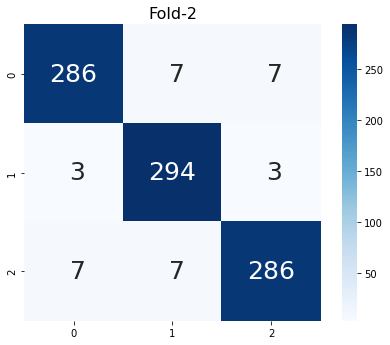

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_cst_nb = confusion_matrix(y_label, pred)
# cm_txc_nb

plt.figure(figsize=(17,12))
# plt.suptitle('Confusion Matrix: XLM-R ', fontsize=20)

plt.subplot(2,2,1)
plt.title('Fold-2', fontsize=16)
df_cm_cst_nb = pd.DataFrame(cm_cst_nb)#, index=np.unique(cst_train), columns=np.unique(cst_test))
sns.heatmap(df_cm_cst_nb, annot=True, square=True, annot_kws={"size": 25}, fmt='2g', cmap='Blues')
print(classification_report(y_label, pred, digits = 4))
model.evaluate(danhgia_input,test.label,verbose=2)

In [ ]:
gold_label = pd.read_json("/content/drive/MyDrive/tinyeudau/gold_lbale_kflod8.json")
pre_label = pd.read_json("/content/drive/MyDrive/tinyeudau/pedict_lbale_kflod8.json")

In [ ]:
gold_label['gold_label'].map({'agree': 0, 'neutral': 1, 'disagree': 2})
pre_label['label'].map({'agree': 0, 'neutral': 1, 'disagree': 2})

0       1
1       2
2       2
3       2
4       0
       ..
1612    0
1613    1
1614    0
1615    2
1616    2
Name: label, Length: 1617, dtype: int64

In [ ]:
y_label = gold_label["gold_label"].to_list()
y_red = pre_label["label"].to_list()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import seaborn as sns
# import metrics
# pred=[np.argmax(i) for i in model.predict(danhgia_input)]
cm_cst_nb = confusion_matrix(y_label, y_pred)
# cm_txc_nb

plt.figure(figsize=(17,12))
# plt.suptitle('Confusion Matrix: XLM-R ', fontsize=20)

plt.subplot(2,2,1)
plt.title('Fold-'+str(i+1), fontsize=16)
df_cm_cst_nb = pd.DataFrame(cm_cst_nb)#, index=np.unique(cst_train), columns=np.unique(cst_test))
print(sns.heatmap(df_cm_cst_nb, annot=True, square=True, annot_kws={"size": 25}, fmt='2g', cmap='Blues'))
print(classification_report(y_label, y_pred, digits = 4))
# model.evaluate(danhgia_input,test.label,verbose=2)

ValueError: ignored

0
AxesSubplot(0.164572,0.536818;0.242246x0.343182)
              precision    recall  f1-score   support

           0     0.9263    0.9633    0.9444       300
           1     0.9728    0.9533    0.9630       300
           2     0.9490    0.9300    0.9394       300

    accuracy                         0.9489       900
   macro avg     0.9494    0.9489    0.9489       900
weighted avg     0.9494    0.9489    0.9489       900

29/29 - 11s - loss: 0.1862 - accuracy: 0.9489
1
AxesSubplot(0.164572,0.536818;0.242246x0.343182)
              precision    recall  f1-score   support

           0     0.9539    0.9667    0.9603       300
           1     0.9600    0.9600    0.9600       300
           2     0.9595    0.9467    0.9530       300

    accuracy                         0.9578       900
   macro avg     0.9578    0.9578    0.9578       900
weighted avg     0.9578    0.9578    0.9578       900

29/29 - 11s - loss: 0.1542 - accuracy: 0.9578
2
AxesSubplot(0.164572,0.536818;0.242246x0.3

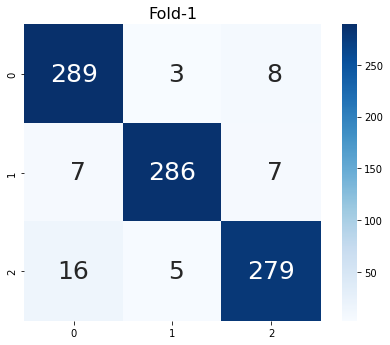

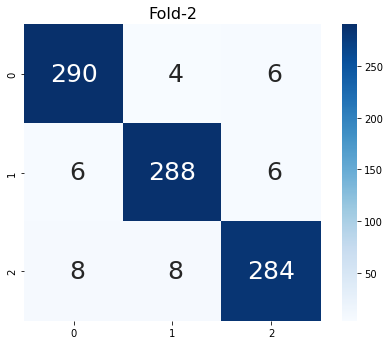

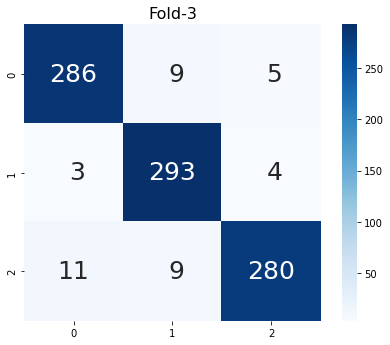

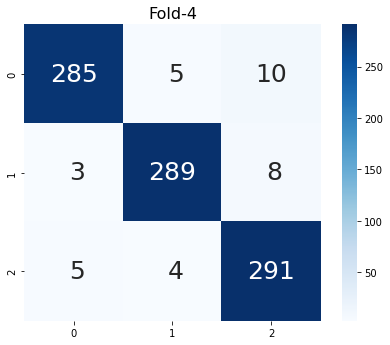

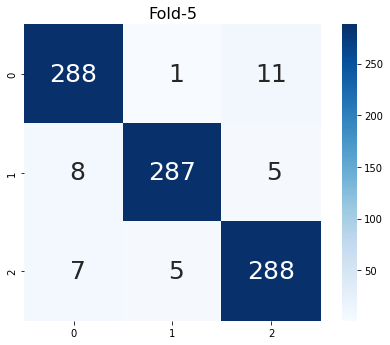

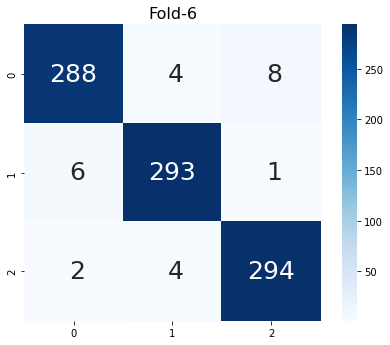

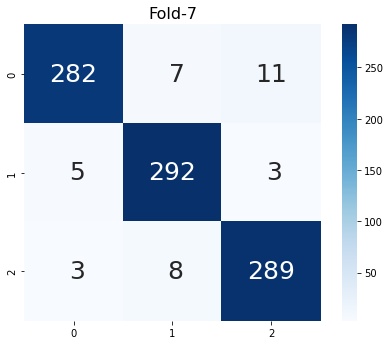

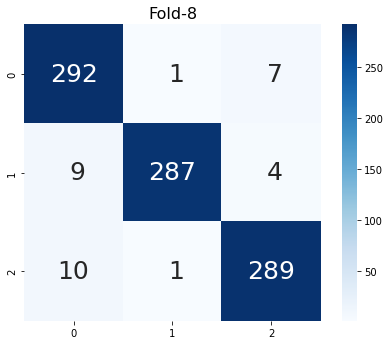

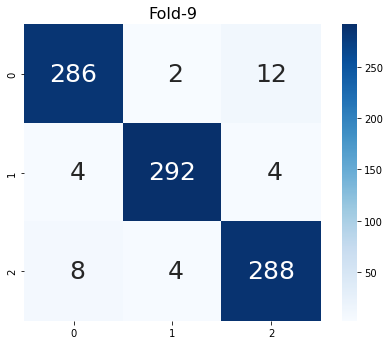

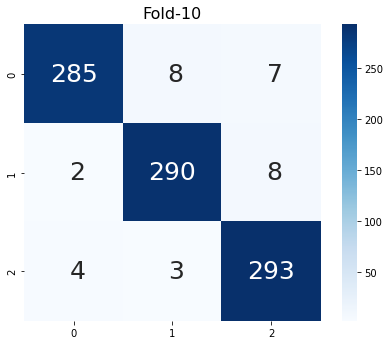

In [ ]:
for i in range(10):
  print(i)
  model.load_weights("/content/drive/MyDrive/VLSP/save/weight_vi/flod"+str(i)+"-0003.ckpt")
  pred=[np.argmax(i) for i in model.predict(danhgia_input)]
  cm_cst_nb = confusion_matrix(y_label, pred)
# cm_txc_nb

  plt.figure(figsize=(17,12))
# plt.suptitle('Confusion Matrix: XLM-R ', fontsize=20)

  plt.subplot(2,2,1)
  plt.title('Fold-'+str(i+1), fontsize=16)
  df_cm_cst_nb = pd.DataFrame(cm_cst_nb)#, index=np.unique(cst_train), columns=np.unique(cst_test))
  print(sns.heatmap(df_cm_cst_nb, annot=True, square=True, annot_kws={"size": 25}, fmt='2g', cmap='Blues'))
  print(classification_report(y_label, pred, digits = 4))
  model.evaluate(danhgia_input,test.label,verbose=2)
  


#load weight



In [ ]:
checkpoint_path = "/content/drive/MyDrive/VLSP/save/weight_vi/flod0-0001.ckpt.index"
checkpoint_dir = os.path.dirname(checkpoint_path)

NameError: ignored

In [ ]:
cd /content/drive/MyDrive/VLSP/save/weight_vi

/content/drive/MyDrive/VLSP/save/weight_vi


In [ ]:
! du -sh /content/drive/MyDrive/

221G	/content/drive/MyDrive/VLSP


# visualize


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams
import string,re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings,os

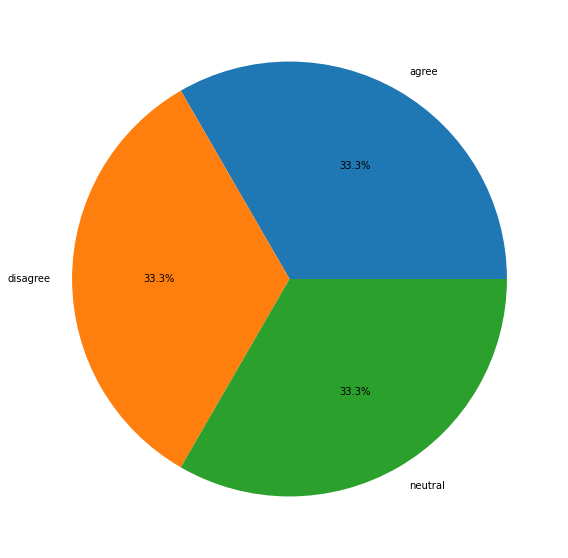

In [ ]:
labels, frequencies = np.unique(train.label.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

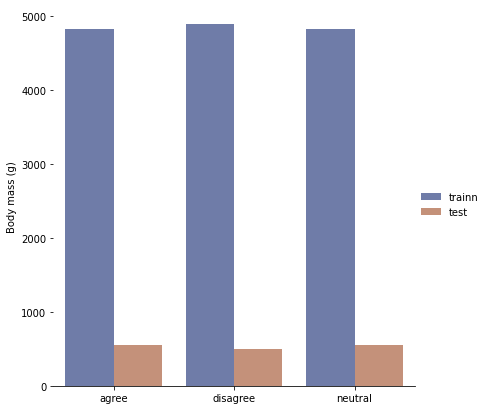

In [ ]:
# train_txt['sentiment_class'] = train_txt['sentiment'].map({0:'negative',1:'positive',-1:'neutral'})
# test_txt['sentiment_class'] = test_txt['sentiment'].map({0:'negative',1:'positive',-1:'neutral'})

num_label=3
trainn_=pd.DataFrame({'count' : train_df_list[1].groupby( [ "label"] ).size(),'hue_':['trainn']*num_label}).reset_index()
testt_=pd.DataFrame({'count' : val_df_list[1].groupby( [ "label"] ).size(),'hue_':['test']*num_label}).reset_index()

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=trainn_.append(testt_), kind="bar",
    x="label", y="count", hue="hue_",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")
